In [1]:
import pandas as pd
import plotly.graph_objects as go
from shapely import wkt
from shapely.geometry import MultiPolygon, Polygon
import numpy as np

file_name = r"C:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\script\outputs\jsons\wkt_v90.csv"
df = pd.read_csv(file_name)
df = df[df['geometry_wkt'].notnull()]


fig = go.Figure()

# Color map setup
thematic_colors = {}
color_palette = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'gray', 'brown']
color_index = 0

# Track bounds for aspect ratio
all_x, all_y, all_z = [], [], []

# Parse and plot each geometry
for _, row in df.iterrows():
    try:
        geom = wkt.loads(row['geometry_wkt'])
        thematic = row['thematic_surface']
        element_id = row['element_id']

        if thematic not in thematic_colors:
            thematic_colors[thematic] = color_palette[color_index % len(color_palette)]
            color_index += 1
        color = thematic_colors[thematic]

        if isinstance(geom, MultiPolygon):
            for polygon in geom.geoms:
                for ring in [polygon.exterior] + list(polygon.interiors):
                    coords = np.array(ring.coords)
                    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
                    all_x.extend(x)
                    all_y.extend(y)
                    all_z.extend(z)

                    fig.add_trace(go.Scatter3d(
                        x=x, y=y, z=z,
                        mode='lines',
                        name=f'{thematic} (ID: {element_id})',
                        line=dict(color=color),
                        text=[f"ID: {element_id}"] * len(x),
                        hoverinfo='text'
                    ))
    except Exception as e:
        print(f"Error processing element {row['element_id']}: {e}")

# Aspect ratio based on data range
x_range = max(all_x) - min(all_x)
y_range = max(all_y) - min(all_y)
z_range = max(all_z) - min(all_z)
max_range = max(x_range, y_range, z_range)
aspect_ratio = {
    "x": x_range / max_range,
    "y": y_range / max_range,
    "z": z_range / max_range
}

fig.update_layout(
    title='3D Visualization of Thematic Surfaces',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='manual',
        aspectratio=aspect_ratio
    ),
    legend_title='Thematic Surface',
    width=1200,   # increased width
    height=800    # increased height
)

fig.show()



MESHES FROM WKT

In [2]:
import trimesh
from shapely import wkt
from shapely.geometry import Polygon, MultiPolygon
import numpy as np

def shapely_to_trimesh(poly: Polygon):
    coords = np.array(poly.exterior.coords)
    if len(coords) < 3:
        return None

    # Triangulate using fan (naive but works for flat faces)
    vertices = coords
    faces = [[0, i, i+1] for i in range(1, len(coords) - 1)]
    return trimesh.Trimesh(vertices=vertices, faces=faces, process=False)

# Convert WKT to meshes
meshes = []
for wkt_str in df['geometry_wkt'].dropna():
    geom = wkt.loads(wkt_str)
    if isinstance(geom, Polygon):
        m = shapely_to_trimesh(geom)
        if m: meshes.append(m)
    elif isinstance(geom, MultiPolygon):
        for p in geom.geoms:
            m = shapely_to_trimesh(p)
            if m: meshes.append(m)

wkt_combined = trimesh.util.concatenate(meshes)


In [3]:
obj_mesh = trimesh.load(r"C:\Users\oscar\OneDrive - Fondazione Bruno Kessler\KUL_GeometricModel\outputs\school.obj")

def center_mesh(mesh):
    mesh.apply_translation(-mesh.centroid)
    return mesh

wkt_centered = center_mesh(wkt_combined.copy())
obj_centered = center_mesh(obj_mesh.copy())

import open3d as o3d
import trimesh

def trimesh_to_o3d(mesh):
    o3d_mesh = o3d.geometry.TriangleMesh()
    o3d_mesh.vertices = o3d.utility.Vector3dVector(mesh.vertices)
    o3d_mesh.triangles = o3d.utility.Vector3iVector(mesh.faces)
    o3d_mesh.compute_vertex_normals()
    return o3d_mesh

# Convert trimesh -> Open3D
source_o3d = trimesh_to_o3d(obj_centered)
target_o3d = trimesh_to_o3d(wkt_centered)

# Sample uniform point clouds
source_pc = source_o3d.sample_points_uniformly(number_of_points=5000)
target_pc = target_o3d.sample_points_uniformly(number_of_points=5000)

# Set ICP parameters
threshold = 1.0
trans_init = np.identity(4)  # start with identity

# Run ICP
reg_result = o3d.pipelines.registration.registration_icp(
    source=source_pc,
    target=target_pc,
    max_correspondence_distance=threshold,
    init=trans_init,
    estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint()
)

# Apply transformation to the original mesh
transform = reg_result.transformation
print("ICP Transformation Matrix:\n", transform)

# Apply to the Trimesh object
obj_centered.apply_transform(transform)



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
ICP Transformation Matrix:
 [[ 9.99987263e-01  5.01048837e-03 -6.07217620e-04 -3.96430589e-01]
 [-5.01009759e-03  9.99987242e-01  6.43394929e-04 -4.68197329e-01]
 [ 6.10433596e-04 -6.40344515e-04  9.99999609e-01  7.00102248e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


<trimesh.Trimesh(vertices.shape=(253, 3), faces.shape=(153, 3))>

In [ ]:
voxel_size = 0.075

def rescale_mesh(mesh, scale_factor):
    """Applies a uniform scale to a trimesh mesh (around its centroid)."""
    center = mesh.centroid
    mesh.apply_translation(-center)
    mesh.apply_scale(scale_factor)
    mesh.apply_translation(center)
    return mesh

# --- Rescale OBJ model ---
scale_factor = 1.01  # Try tweaking this
obj_centered_scaled = obj_centered.copy()
rescale_mesh(obj_centered_scaled, scale_factor)

# --- Voxelize both models ---
wkt_vox = wkt_centered.voxelized(pitch=voxel_size)
obj_vox = obj_centered_scaled.voxelized(pitch=voxel_size)  # ✅ use scaled mesh

wkt_bool = wkt_vox.matrix
obj_bool = obj_vox.matrix

# Match voxel grid shapes
min_shape = np.minimum(wkt_bool.shape, obj_bool.shape)
wkt_bool = wkt_bool[:min_shape[0], :min_shape[1], :min_shape[2]]
obj_bool = obj_bool[:min_shape[0], :min_shape[1], :min_shape[2]]

# --- Apply buffer with dilation ---
from scipy.ndimage import binary_dilation

buffer_mm = 30  # tolerance in mm
buffer_voxels = int(np.ceil(buffer_mm / (voxel_size * 1000)))  # mm → voxel count

wkt_dil = binary_dilation(wkt_bool, iterations=buffer_voxels)

# --- Compute metrics with buffer ---
tp = np.logical_and(obj_bool, wkt_dil).sum()
fp = np.logical_and(obj_bool, ~wkt_dil).sum()
fn = np.logical_and(wkt_bool, ~obj_bool).sum()

precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
iou = tp / (tp + fp + fn) if (tp + fp + fn) else 0

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"IoU:       {iou:.3f}")




Precision: 0.713
Recall:    0.413
F1 Score:  0.523
IoU:       0.354


NameError: name 'trimesh_to_plotly_mesh' is not defined

In [5]:
from scipy.ndimage import binary_dilation

# Define buffer in meters
tolerance_m = 0.025 # e.g. 10 cm
buffer_voxels = int(np.ceil(tolerance_m / voxel_size))

# Dilate both masks
wkt_dilated = binary_dilation(wkt_bool, iterations=buffer_voxels)
obj_dilated = binary_dilation(obj_bool, iterations=buffer_voxels)

# Intersection & union with buffer
intersection = np.logical_and(wkt_dilated, obj_bool).sum()
union = np.logical_or(wkt_bool, obj_bool).sum()

# Compute metrics
precision = intersection / obj_bool.sum()
recall = intersection / wkt_bool.sum()
f1 = 2 * (precision * recall) / (precision + recall)
iou = intersection / union

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"IoU:       {iou:.3f}")


Precision: 0.713
Recall:    0.457
F1 Score:  0.557
IoU:       0.354


In [8]:
import plotly.graph_objects as go
import numpy as np

def trimesh_to_plotly_mesh(mesh, name, color='blue', opacity=0.5):
    vertices = mesh.vertices
    faces = mesh.faces

    return go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        name=name,
        color=color,
        opacity=opacity
    )


In [11]:
from scipy.ndimage import binary_dilation

# Define buffer in meters
tolerance_m = 0.20
buffer_voxels = int(np.ceil(tolerance_m / voxel_size))

# Dilate WKT (ground truth) slightly, not OBJ (prediction)
wkt_dilated = binary_dilation(wkt_bool, iterations=buffer_voxels)

# True Positives = pred inside dilated ground truth
tp = np.logical_and(obj_bool, wkt_dilated).sum()

# False Positives = pred outside ground truth
fp = np.logical_and(obj_bool, ~wkt_dilated).sum()

# False Negatives = ground truth missed by pred
fn = np.logical_and(wkt_bool, ~obj_bool).sum()

# Precision = TP / (TP + FP)
# Recall    = TP / (TP + FN)
precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
iou = tp / (tp + fp + fn) if (tp + fp + fn) else 0

# Output
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")
print(f"IoU:       {iou:.3f}")

# Use scaled OBJ model
obj_trace = trimesh_to_plotly_mesh(obj_centered_scaled, 'OBJ Model (Scaled)', color='red', opacity=0.5)
wkt_trace = trimesh_to_plotly_mesh(wkt_centered, 'WKT Model', color='blue', opacity=0.5)

fig = go.Figure(data=[wkt_trace, obj_trace])
fig.update_layout(
    title='Overlay of WKT and Scaled OBJ Models',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    ),
    width=1000,
    height=800,
    legend=dict(x=0.7, y=0.9)
)
fig.show()



Precision: 0.922
Recall:    0.476
F1 Score:  0.628
IoU:       0.458


In [15]:
def recover_metrics(precision, f1):
    # Compute Recall from F1 and Precision
    if precision == 0 or f1 == 0:
        recall = 0
    else:
        recall = (f1 * precision) / (2 * precision - f1)

    # Compute IoU from Precision and Recall
    if precision + recall - (precision * recall) == 0:
        iou = 0
    else:
        iou = (precision * recall) / (precision + recall - (precision * recall))

    return recall, iou

# Example
precision = 0.894
f1 = 0.875

recall, iou = recover_metrics(precision, f1)

print(f'Precision {precision:.3f}')
print(f'F1: {f1:.3f}')
print(f"Recovered Recall: {recall:.3f}")
print(f"Estimated IoU:    {iou:.3f}")


Precision 0.894
F1: 0.875
Recovered Recall: 0.857
Estimated IoU:    0.778


In [17]:
def recover_metrics_from_precision_iou(precision, iou):
    # Compute Recall from Precision and IoU
    if precision == 0 or iou == 0:
        recall = 0
    else:
        recall = (iou * precision) / (precision - iou * (precision - 1))

    # Compute F1 from Precision and Recall
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    return recall, f1

# Example
precision = 0.911
iou = 0.881

recall, f1 = recover_metrics_from_precision_iou(precision, iou)

print(f'Precision: {precision:.3f}')
print(f'IoU:       {iou:.3f}')
print(f'Recovered Recall: {recall:.3f}')
print(f'Recomputed F1:    {f1:.3f}')


Precision: 0.911
IoU:       0.881
Recovered Recall: 0.811
Recomputed F1:    0.858


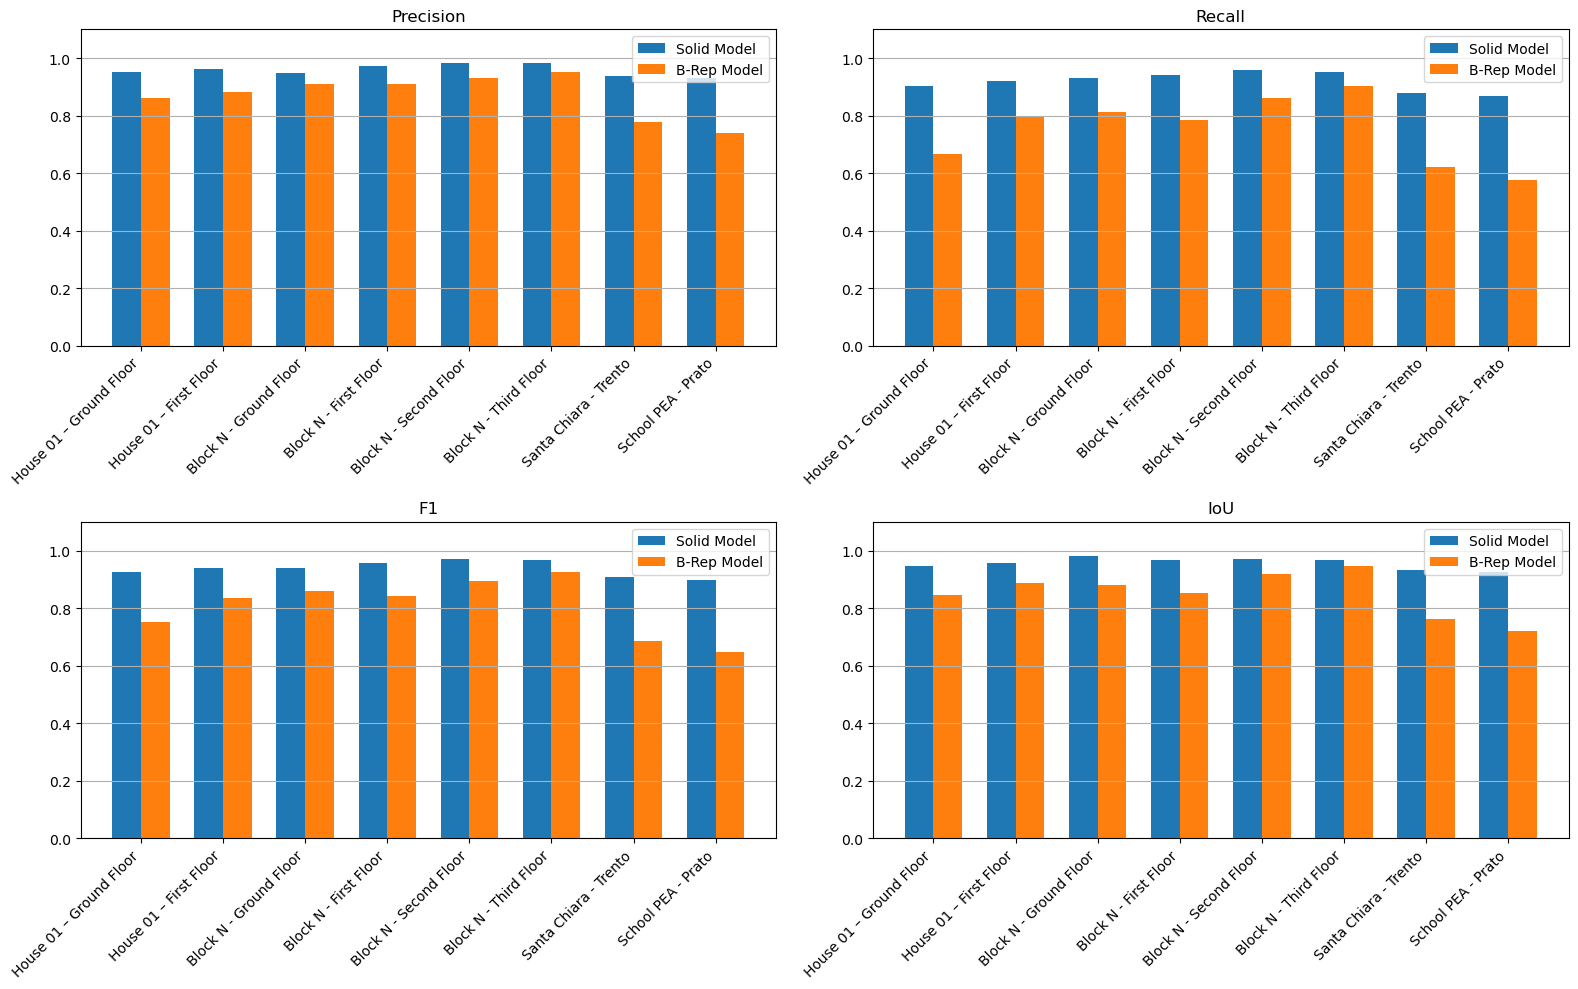

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the data
data = {
    "Dataset": [
        "House 01 – Ground Floor", "House 01 – First Floor",
        "Block N - Ground Floor", "Block N - First Floor",
        "Block N - Second Floor", "Block N - Third Floor",
        "Santa Chiara - Trento", "School PEA - Prato"
    ],
    "Solid_Precision": [0.950, 0.961, 0.947, 0.973, 0.984, 0.983, 0.937, 0.930],
    "Solid_Recall": [0.903, 0.922, 0.930, 0.943, 0.957, 0.953, 0.879, 0.867],
    "Solid_F1": [0.926, 0.941, 0.938, 0.958, 0.970, 0.968, 0.907, 0.897],
    "Solid_IoU": [0.948, 0.958, 0.981, 0.968, 0.972, 0.969, 0.934, 0.927],
    "BRep_Precision": [0.861, 0.882, 0.911, 0.909, 0.931, 0.951, 0.778, 0.741],
    "BRep_Recall": [0.667, 0.795, 0.811, 0.785, 0.860, 0.904, 0.620, 0.576],
    "BRep_F1": [0.751, 0.836, 0.858, 0.842, 0.894, 0.927, 0.686, 0.648],
    "BRep_IoU": [0.847, 0.889, 0.881, 0.852, 0.919, 0.948, 0.763, 0.721]
}

df = pd.DataFrame(data)

# Plotting grouped bar charts
metrics = ["Precision", "Recall", "F1", "IoU"]
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.flatten()

x = range(len(df["Dataset"]))
bar_width = 0.35

for i, metric in enumerate(metrics):
    ax = axs[i]
    ax.bar([p - bar_width / 2 for p in x], df[f"Solid_{metric}"], width=bar_width, label='Solid Model')
    ax.bar([p + bar_width / 2 for p in x], df[f"BRep_{metric}"], width=bar_width, label='B-Rep Model')
    ax.set_title(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(df["Dataset"], rotation=45, ha='right')
    ax.set_ylim(0, 1.1)
    ax.legend()
    ax.grid(axis='y')

fig.tight_layout()
plt.show()


Text(0.5, 0.98, 'COMPARISON OF SOLID vs B-REP MODEL ACROSS DATASETS')

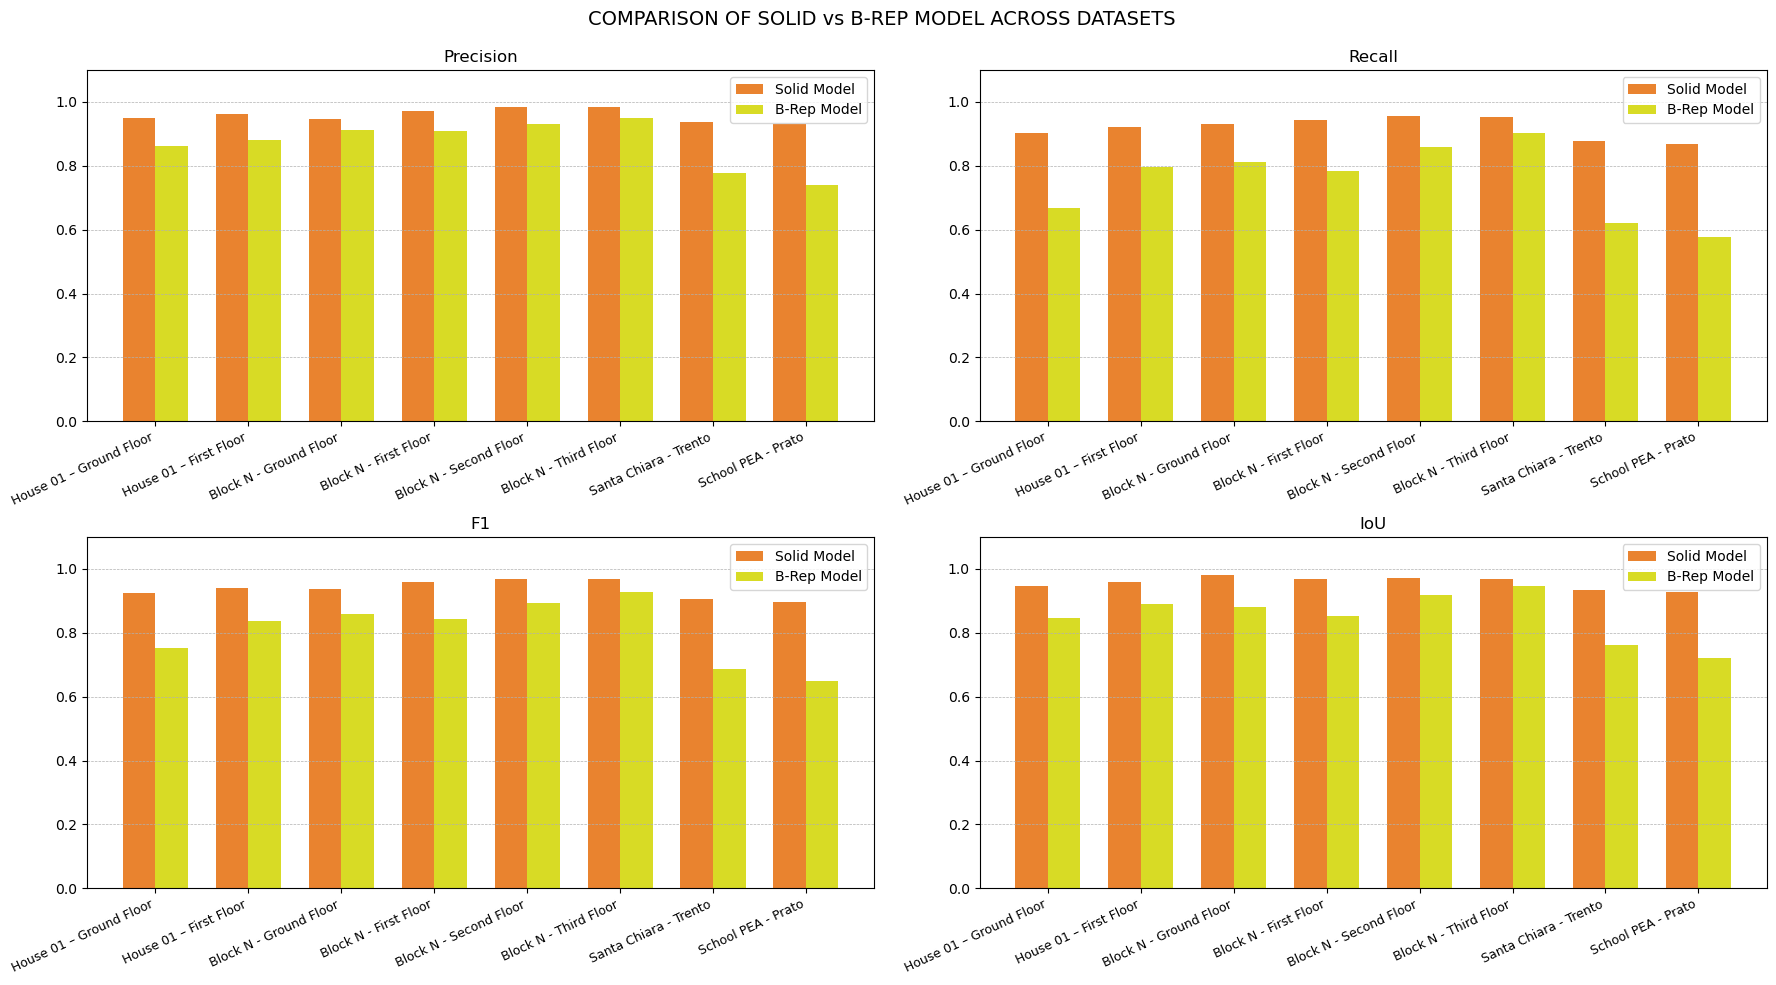

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define datasets and metrics
datasets = [
    "House 01 – Ground Floor", "House 01 – First Floor",
    "Block N - Ground Floor", "Block N - First Floor",
    "Block N - Second Floor", "Block N - Third Floor",
    "Santa Chiara - Trento", "School PEA - Prato"
]

metrics = ["Precision", "Recall", "F1", "IoU"]

# Solid model metrics
solid = np.array([
    [0.950, 0.903, 0.926, 0.948],
    [0.961, 0.922, 0.941, 0.958],
    [0.947, 0.930, 0.938, 0.981],
    [0.973, 0.943, 0.958, 0.968],
    [0.984, 0.957, 0.970, 0.972],
    [0.983, 0.953, 0.968, 0.969],
    [0.937, 0.879, 0.907, 0.934],
    [0.930, 0.867, 0.897, 0.927]
])

# B-Rep model metrics
brep = np.array([
    [0.861, 0.667, 0.751, 0.847],
    [0.882, 0.795, 0.836, 0.889],
    [0.911, 0.811, 0.858, 0.881],
    [0.909, 0.785, 0.842, 0.852],
    [0.931, 0.860, 0.894, 0.919],
    [0.951, 0.904, 0.927, 0.948],
    [0.778, 0.620, 0.686, 0.763],
    [0.741, 0.576, 0.648, 0.721]
])

# Colors and styles
colors = ["#E9832F", "#D8DB25"]
width = 0.35
x = np.arange(len(datasets))

fig, axs = plt.subplots(2, 2, figsize=(18, 10))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    ax = axs[i]
    ax.bar(x - width / 2, solid[:, i], width, label='Solid Model', color=colors[0])
    ax.bar(x + width / 2, brep[:, i], width, label='B-Rep Model', color=colors[1])
    ax.set_title(metric, fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(datasets, rotation=25, ha='right', fontsize=9)
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', linestyle='--', linewidth=0.5)
    ax.legend()

fig.tight_layout()
plt.subplots_adjust(top=0.92)
fig.suptitle("COMPARISON OF SOLID vs B-REP MODEL ACROSS DATASETS", fontsize=14)




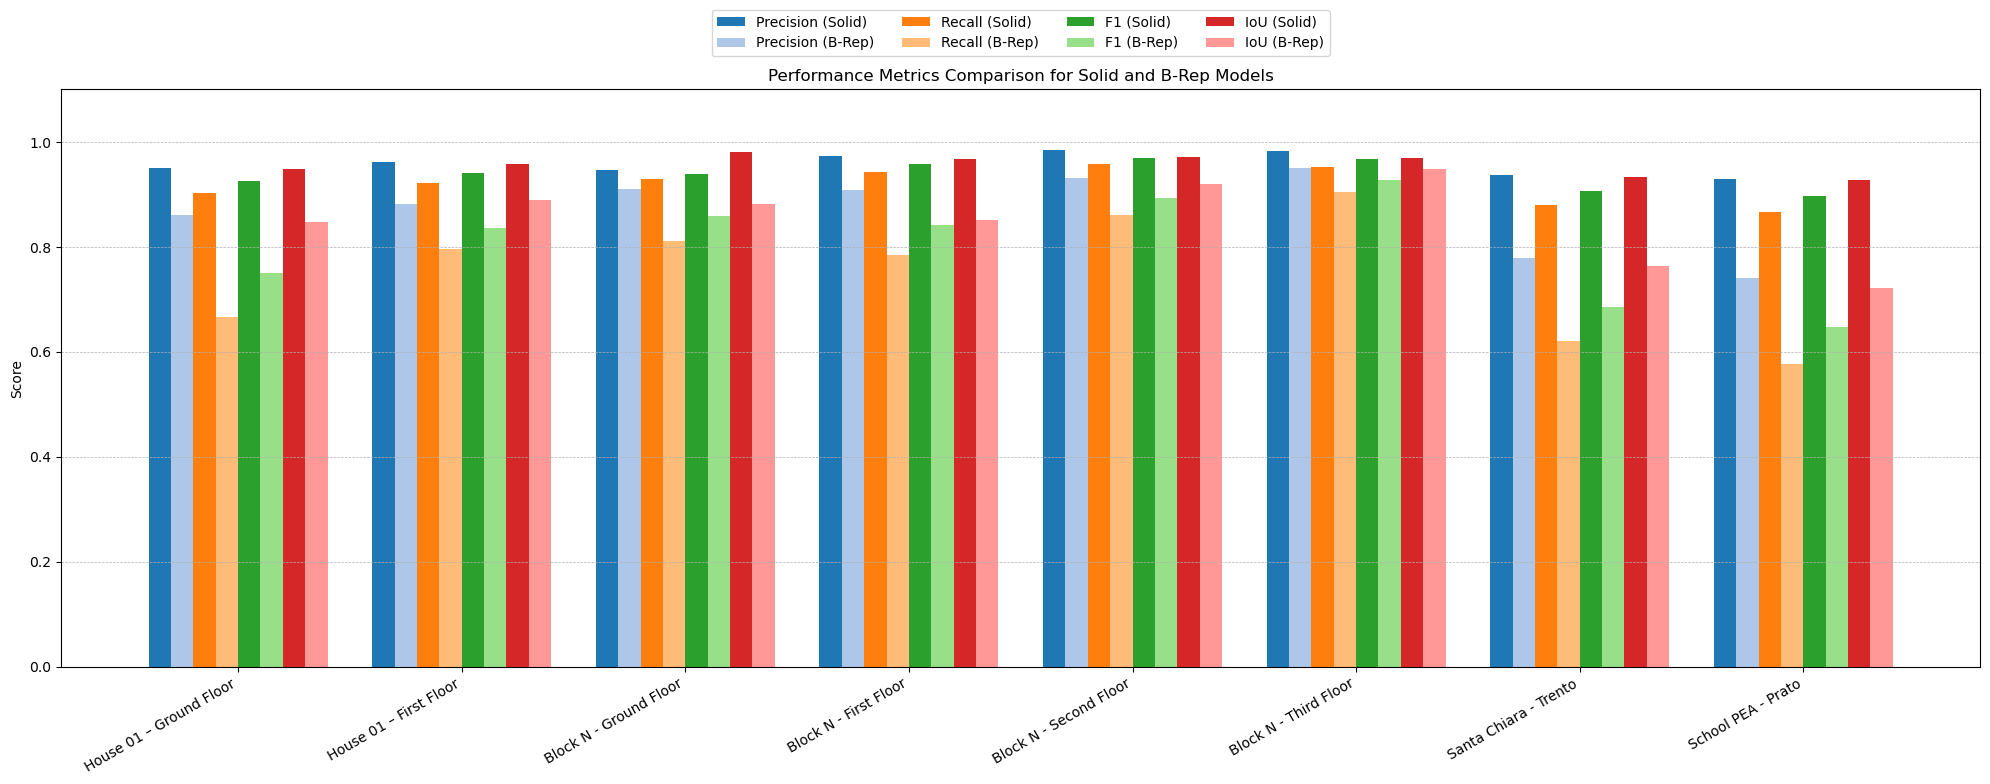

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Define datasets and metrics
datasets = [
    "House 01 – Ground Floor", "House 01 – First Floor",
    "Block N - Ground Floor", "Block N - First Floor",
    "Block N - Second Floor", "Block N - Third Floor",
    "Santa Chiara - Trento", "School PEA - Prato"
]

metrics = ["Precision", "Recall", "F1", "IoU"]

# Solid model metrics
solid = np.array([
    [0.950, 0.903, 0.926, 0.948],
    [0.961, 0.922, 0.941, 0.958],
    [0.947, 0.930, 0.938, 0.981],
    [0.973, 0.943, 0.958, 0.968],
    [0.984, 0.957, 0.970, 0.972],
    [0.983, 0.953, 0.968, 0.969],
    [0.937, 0.879, 0.907, 0.934],
    [0.930, 0.867, 0.897, 0.927]
])

# B-Rep model metrics
brep = np.array([
    [0.861, 0.667, 0.751, 0.847],
    [0.882, 0.795, 0.836, 0.889],
    [0.911, 0.811, 0.858, 0.881],
    [0.909, 0.785, 0.842, 0.852],
    [0.931, 0.860, 0.894, 0.919],
    [0.951, 0.904, 0.927, 0.948],
    [0.778, 0.620, 0.686, 0.763],
    [0.741, 0.576, 0.648, 0.721]
])

# Grouped bar plot
x = np.arange(len(datasets))
width = 0.1  # Narrower bars for clarity

fig, ax = plt.subplots(figsize=(20, 8))

# Define new color palette
colors = {
    "Precision (Solid)": "#1f77b4",
    "Precision (B-Rep)": "#aec7e8",
    "Recall (Solid)": "#ff7f0e",
    "Recall (B-Rep)": "#ffbb78",
    "F1 (Solid)": "#2ca02c",
    "F1 (B-Rep)": "#98df8a",
    "IoU (Solid)": "#d62728",
    "IoU (B-Rep)": "#ff9896"
}

# Plot each bar with appropriate offset and color
for i, metric in enumerate(metrics):
    ax.bar(x + (i * 2 - 3.5) * width, solid[:, i], width, label=f"{metric} (Solid)", color=colors[f"{metric} (Solid)"])
    ax.bar(x + (i * 2 - 2.5) * width, brep[:, i], width, label=f"{metric} (B-Rep)", color=colors[f"{metric} (B-Rep)"])

# Styling
ax.set_ylabel("Score")
ax.set_title("Performance Metrics Comparison for Solid and B-Rep Models")
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=30, ha='right')
ax.set_ylim(0, 1.1)
ax.grid(axis='y', linestyle='--', linewidth=0.5)
ax.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.15))

plt.tight_layout()
plt.show()
